# <font color='BLUE'> DAB402 - CAPSTONE PROJECT </font>
# <font color='BLUE'> SENTIMENT ANALYSIS IN SHORT-TERM RENTAL INDUSTRY  </font>

#### <font color='BLUE'>Group Name: Snowflake   </font>  
   - Trang Bui- W0753523 

### <font color='purple'>Import libraries</font> 

In [1]:
# # Import the appropriate Libraries
# import warnings
# warnings.simplefilter(action='ignore', category=DeprecationWarning)
    
import os, sys    
from datetime import datetime, date
import numpy as np
import pandas as pd # for dataframes
import tensorflow as tf
import io
import re
import shutil
import string
import tensorflow as tf
import time

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, Conv1D, LSTM
# from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import plotly.graph_objs as go #visualization
import plotly.offline as py#visualization
import itertools

# <font color='RED'> Features Extraction using Keras </font>


## TEXT PROCESSING

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
# Cleaning & Preprocessing Text Data
import nltk
nltk.download('stopwords');
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from contractions import CONTRACTION_MAP
from nltk.corpus import wordnet

start_time = time.time()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_nomalization(df,colname):
    # remove empty rows
    df=df.dropna()
    # remove number in the review sentences
    df.loc[:,(colname)] = df[colname].str.replace('\d+', '')
    # remove_punctuation
    df.loc[:,(colname)] = df[colname].str.replace('[^\w\s]', '') 
    df.loc[:,(colname)] = df[colname].str.replace(r'[^\x00-\x7F]+', '')
    df.loc[:,(colname)] = df[colname].str.lower()
    # remove duplicated comments/reviews
    df.drop_duplicates(subset=colname, keep = "first", inplace = True)
    return df

def remove_html(text):
    soup= BeautifulSoup(text,'lxml')
    html_free = soup.get_text()
    return html_free

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def remove_stopwords(text):
    words = [word for word in nltk.word_tokenize(text) if word not in stopwords.words('english')]    
    return words

def word_lemmatizer(text):
    lem_text = ([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text])
#     clean_text = ' '.join(word for word in lem_text)
    return lem_text

def word_stemmer(text):
    stem_text = ([stemmer.stem(word) for word in text])
    #clean_text = ' '.join(word for word in stem_text)
    return stem_text

def join(token_text):
    sent = ' '.join(word for word in token_text)
    return sent

def text_processing(df,colname, do_stemmer=1):
    start_process = time.time()
    df = text_nomalization(df,colname)    
    print("+++++ text_nomalization duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: remove_html(x))
    print("+++++ remove_html duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: expand_contractions(x))
    print("+++++ expand_contractions duration--- %s seconds ---" % (time.time() - start_process))
    
#     start_process = time.time()    
#     df[colname] = df[colname].apply(lambda x: tokenizer.tokenize(x.lower()))
#     print("+++++ tokenizer duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: remove_stopwords(x))
    print("+++++ remove_stopwords duration--- %s seconds ---" % (time.time() - start_process))
  
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: word_lemmatizer(x))
    print("+++++ word_lemmatizer duration--- %s seconds ---" % (time.time() - start_process))

    if (do_stemmer==1):
        start_process = time.time()    
        df.loc[:,(colname)] = df[colname].apply(lambda x: word_stemmer(x))
        print("+++++ word_stemmer duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: join(x))
    print("+++++ join duration--- %s seconds ---" % (time.time() - start_process))
    
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\teres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# <font color='RED'> Sampling and Splitting </font>

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

input_folder = './data/input_output_csv/raw_data/'
buffer_folder = './data/input_output_csv/buffer/'
sampling_folder = './data/input_output_csv/cleaned_data/'
saved_models = './data/saved_models/'
saved_embedding = './data/saved_embedding/'

big_sample = 1
if (big_sample == 1):
    df = pd.read_csv(sampling_folder + 'sample_reviews_FULL.csv')
else:
    df = pd.read_csv(sampling_folder + 'sample_reviews.csv')

# df_orig = pd.read_csv(input_folder + 'reviews_sample_CLEAN.csv')
# df_orig.loc[df_orig.label=='POSITIVE','label']= 1
# df_orig.loc[df_orig.label=='NEUTRAL','label']= 0
# df_orig.loc[df_orig.label=='NEGATIVE','label']=-1

df['comments'] = df['comments_orig']
df = text_processing(df,'comments',do_stemmer=0) 

print('df_shape:',df.shape)
df.head(8)

+++++ text_nomalization duration--- 0.20245862007141113 seconds ---
+++++ remove_html duration--- 2.0725085735321045 seconds ---
+++++ expand_contractions duration--- 4.846979379653931 seconds ---
+++++ remove_stopwords duration--- 115.06080508232117 seconds ---
+++++ word_lemmatizer duration--- 134.61372542381287 seconds ---
+++++ join duration--- 0.031914472579956055 seconds ---
df_shape: (9194, 6)


,listing_id,comments,label,city,lang,comments_orig
0,241212,host cancel reservation day arrival automate post,NEUTRAL,montreal,en,The host canceled this reservation 90 days bef...
1,24673795,samuel responsive host time day however really...,NEGATIVE,montreal,en,Samuel is a very responsive host at any time a...
2,22324437,goood bathroom problem water leakes toilet,NEGATIVE,toronto,en,There was so goood but have bathroom problems....
3,20903175,ample bedding bathroom clean update host provi...,NEGATIVE,ottawa,en,There was ample bedding. The bathrooms were cl...
4,23882081,house smell bad amenity smell bad well bed one...,NEGATIVE,toronto,en,House smells bad and amenities smell bad as we...
5,21160812,good value money apartment good location safe ...,POSITIVE,toronto,en,Good value for the money. The apartment is in ...
6,35771330,great place w lot attention detail absolutely ...,POSITIVE,toronto,en,Great place w lots of attention to detail. Abs...
7,44685213,fantastic location slight trouble check host r...,POSITIVE,montreal,en,"Fantastic location, slight trouble checking in..."


In [4]:
## Initial
# Dataframe to store accuracy information
df_score = pd.DataFrame()
df_confusion = pd.DataFrame()

def train_test_splitting(X, Y, pct_train, pct_val, is_random): 
    x_val=[]
    y_val=[]
    if (is_random == 1):        
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-pct_train), random_state=prandom_state)
        if (pct_val>0):
            x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size= (pct_val/(1-pct_train)), random_state=prandom_state)
    else:
        nb_observation = X.shape[0]
        end_train = int(np.floor(pct_train*nb_observation))
        end_val = int(np.floor((pct_train + pct_val)*nb_observation))
        
        x_train = X[0:end_train]
        y_train = Y[0:end_train]
        
        x_val = X[end_train:end_val]
        y_val = Y[end_train:end_val]
        
        x_test = X[end_val:]
        y_test = Y[end_val:]
                
    return x_train, y_train, x_test, y_test, x_val, y_val   
   
## Create lists
x_list = []
y_list = []
idx_arr=[]

train_comment=[]
train_label=[]
train_idx=[]

test_comment=[]
test_label=[]
test_idx=[]

val_comment=[]
val_label=[]
val_idx=[]

X=pd.DataFrame(df['comments'])
Y=pd.DataFrame(df['label'])


x_list = X['comments'].values.astype(str).tolist()
y_list = Y['label'].values.tolist()
idx_arr = df.index.tolist()

# Splitting
prandom_state = 523
pct_train = 0.7
pct_val = 0
is_random = 1

x_train, y_train, x_test, y_test, x_val, y_val = train_test_splitting(X,Y, pct_train, pct_val, is_random)

    
print('===================================================================================')  
print('df.shape:',df.shape[0], ' --- ', 'X.shape:', X.shape, ' --- ', 'Y.shape:', Y.shape)
print('x_train.shape:', x_train.shape, ' --- ', 'y_train.shape:', y_train.shape)
if (pct_val>0): 
    print('x_val.shape:', x_val.shape, ' --- ', 'y_val.shape:', y_val.shape)
print('x_test.shape:', x_test.shape, ' --- ', 'y_test.shape:', y_test.shape)
print('===================================================================================')


df.shape: 9194  ---  X.shape: (9194, 1)  ---  Y.shape: (9194, 1)
x_train.shape: (6435, 1)  ---  y_train.shape: (6435, 1)
x_test.shape: (2759, 1)  ---  y_test.shape: (2759, 1)


df.shape:  (9194, 6)


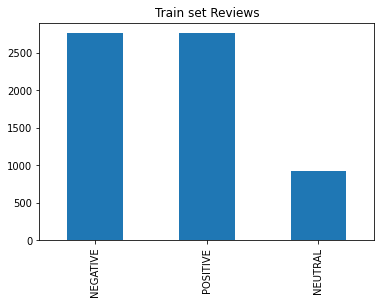

In [5]:
y_train.label.value_counts().plot(kind='bar',title="Train set Reviews")
print('df.shape: ',df.shape)

df.shape:  (9194, 6)


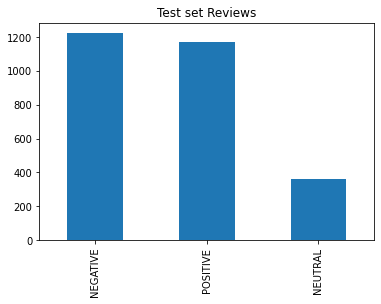

In [6]:
y_test.label.value_counts().plot(kind='bar',title="Test set Reviews")
print('df.shape: ',df.shape)

In [7]:
x_train

,comments
1170,really good experience stay alison house clean...
2661,meh im big fan ottawa number thing wouldnt bla...
7303,charm space great location value
1268,superbe location
5311,want beautiful apartment great part city graci...
...,...
3659,first airbnb experience disappointed kim neil ...
8007,small place mentionned host floor sticky dirty...
6524,clean comfortable apartment youll everything n...
3408,listing accurate heidi specifically mention ba...


In [8]:
y_test.loc[y_test.label=='POSITIVE','label']= 1
y_test.loc[y_test.label=='NEUTRAL','label']= 0
y_test.loc[y_test.label=='NEGATIVE','label']=-1
y_train.loc[y_train.label=='POSITIVE','label']= 1
y_train.loc[y_train.label=='NEUTRAL','label']= 0
y_train.loc[y_train.label=='NEGATIVE','label']=-1
y_train

C:\Users\teres\.conda\envs\DAB402\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\teres\.conda\envs\DAB402\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,label
1170,1
2661,-1
7303,1
1268,0
5311,1
...,...
3659,1
8007,-1
6524,-1
3408,-1


## <font color='RED'> Build Corpus/Dictionary  </font>

https://www.tensorflow.org/tutorials/text/word_embeddings  

https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

In [9]:
# https://keras.io/api/preprocessing/text/
# - Keras supports some functions for text data preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence


# Get the max-length of comments
measurer = np.vectorize(len)
maxlen = measurer(X['comments'].values.astype(str)).max(axis=0)
print('maxlen=',maxlen)

tokenizer=Tokenizer(oov_token="<OOV>")
# build dictionary
tokenizer.fit_on_texts(x_list) 
word2id = tokenizer.word_index

total_vocab = len(word2id)+1
p_vocab_size= total_vocab  #the number of unique words in the list of comments

p_max_length= 80 #the maximum length of the longest comment
p_embedding_dim=64 # 1 word has 100 dimensions (features)


print('p_vocab_size=',p_vocab_size)
print('type(word2id):', type(word2id))
print('Words to ID:',dict(list(word2id.items())[0:100]))

maxlen= 3198
p_vocab_size= 12135
type(word2id): <class 'dict'>
Words to ID: {'<OOV>': 1, 'place': 2, 'stay': 3, 'host': 4, 'great': 5, 'clean': 6, 'apartment': 7, 'location': 8, 'would': 9, 'u': 10, 'get': 11, 'room': 12, 'bed': 13, 'time': 14, 'recommend': 15, 'airbnb': 16, 'dirty': 17, 'one': 18, 'make': 19, 'also': 20, 'night': 21, 'bad': 22, 'house': 23, 'need': 24, 'day': 25, 'go': 26, 'well': 27, 'really': 28, 'even': 29, 'nice': 30, 'everything': 31, 'like': 32, 'walk': 33, 'experience': 34, 'check': 35, 'good': 36, 'close': 37, 'bathroom': 38, 'kitchen': 39, 'book': 40, 'use': 41, 'parking': 42, 'come': 43, 'say': 44, 'didnt': 45, 'door': 46, 'back': 47, 'could': 48, 'work': 49, 'comfortable': 50, 'space': 51, 'floor': 52, 'look': 53, 'home': 54, 'unit': 55, 'definitely': 56, 'take': 57, 'people': 58, 'lot': 59, 'building': 60, 'bedroom': 61, 'area': 62, 'easy': 63, 'guest': 64, 'ask': 65, 'give': 66, 'left': 67, 'towel': 68, 'never': 69, 'toronto': 70, 'broken': 71, 'arrive': 

In [10]:
train_comment = x_train['comments'].values.astype(str).tolist()
train_label = y_train['label'].values.tolist()
train_idx = x_train.index.tolist() 

test_comment = x_test['comments'].values.astype(str).tolist()
test_label = y_test['label'].values.tolist()
test_idx = x_test.index.tolist()

if (pct_val>0):
    val_comment = x_val['comments'].values.astype(str).tolist()
    val_label = y_val['label'].values.tolist()
    val_idx = x_val.index.tolist()
    
    
def convert_sequences(lst_text, max_length):
    lst_text_token_seq=tokenizer.texts_to_sequences(lst_text)    
    padding_arr=pad_sequences(lst_text_token_seq,maxlen=max_length,truncating='post',padding="post")  #padding to make the same length array
    print('train_comment:', lst_text[0:1])
    print('train_comment_seq:',lst_text_token_seq[0:1])
    print('padding_train_comment_seq = ', padding_arr[0:1])
    return padding_arr

padded_train_sequences = convert_sequences(train_comment, p_max_length)
padded_test_sequences =  convert_sequences(test_comment, p_max_length)
train_label_arr=np.array(train_label)
test_label_arr=np.array(test_label)
print('padded_train_sequences.shape',padded_train_sequences.shape)
print('padded_test_sequences.shape',padded_test_sequences.shape)
print('len(train_label_arr)',len(train_label_arr))
print('len(test_label_arr)',len(test_label_arr))
# print('5=',list(word2id.keys())[list(word2id.values()).index(5)])
# print('7=',list(word2id.keys())[list(word2id.values()).index(7)])
# print('512=',list(word2id.keys())[list(word2id.values()).index(512)])
# print('95=', list(word2id.keys())[list(word2id.values()).index(95)])
# print('98=', list(word2id.keys())[list(word2id.values()).index(98)])

train_comment: ['really good experience stay alison house clean comfort']
train_comment_seq: [[28, 36, 34, 3, 3626, 23, 6, 930]]
padding_train_comment_seq =  [[  28   36   34    3 3626   23    6  930    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]]
train_comment: ['least pleasurable airbnb experience host let drop luggage earlier check time everything place umpleasurable experience get give basement room saw listing host insist key deposit return dollar brother stayed one night pmam nothing house rule bathroom wall sink soapholder fill grime area generally unpleasant even complain towel give first brown although suppose white dishware crockery guest notice kitchen say 

In [11]:
train_label_arr

array([ 1, -1,  1, ..., -1, -1,  1])

## <font color='RED'> Train Word Embeddings using some simple Keras model for sentiment classification, then select the best model </font>

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model Name = model_11
p_vocab_size= 12135
p_embedding_dim= 64
p_max_length= 80
p_activation_d1= sigmoid
p_activation_d2= tanh
p_optimizer= adam
p_loss= mse
p_epochs= 100
p_batch_size= 1028
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 64)            776640    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
flatten (Flatten)            (N

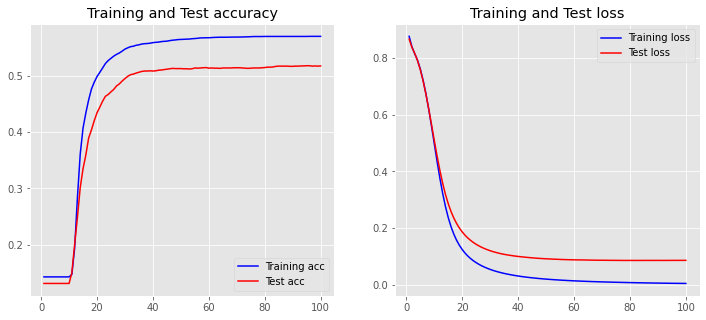

In [12]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#Build model to predict sentiment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, GlobalMaxPool1D
from collections import OrderedDict

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Test acc')
    plt.title('Training and Test accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Test loss')
    plt.title('Training and Test loss')
    plt.legend()

def fit_and_evaluate_model(model, padded_train_sequences,train_label_arr, padded_test_sequences,test_label_arr, p_epochs, p_batch_size):
    start_time = time.time() 
    history=model.fit(padded_train_sequences,train_label_arr, epochs=p_epochs, batch_size=p_batch_size, validation_data=(padded_test_sequences,test_label_arr), verbose=0)
    training_duration = time.time() - start_time
    
    plot_history(history)
    
    # evaluate model
    loss_train, acc_train = model.evaluate(padded_train_sequences,train_label_arr,verbose=0)
    loss_test, acc_test = model.evaluate(padded_test_sequences,test_label_arr,verbose=0)
    print('Accuracy Train: %f' % (acc_train*100))
    print('Loss Train: %f' % (loss_train*100))
    print('Accuracy Test: %f' % (acc_test*100))
    print('Loss Test: %f' % (loss_test*100))
    return loss_train, acc_train, loss_test, acc_test, training_duration

def print_info(p_model_name, p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, p_batch_size, p_epochs):
    print('////////////////////////////////////////////////////////////////////////////////////////////////////////////////////')
    print('Model Name =', p_model_name)
    print('p_vocab_size=',p_vocab_size)
    print('p_embedding_dim=',p_embedding_dim)
    print('p_max_length=',p_max_length)
    print('p_activation_d1=',p_activation_d1)
    print('p_activation_d2=',p_activation_d2)
    print('p_optimizer=',p_optimizer)
    print('p_loss=',p_loss)
    print('p_epochs=',p_epochs)
    print('p_batch_size=',p_batch_size)
    print('////////////////////////////////////////////////////////////////////////////////////////////////////////////////////')
    return

# The Embedding layer has weights that are learned
# The output of the Embedding layer is a 2D vector with one embedding for each word in the input sequence of words
# If you wish to connect a Dense layer directly to an Embedding layer, you must first flatten the 2D output matrix to a 1D vector using the Flatten layer

def create_embedding_1(p_model_name, p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose):
    print_info(p_model_name, p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, p_batch_size, p_epochs)
    
    model = Sequential()
    model.add(Embedding(input_dim=p_vocab_size, output_dim= p_embedding_dim, input_length=p_max_length))   
    model.add(GlobalMaxPool1D()) 
    model.add(Dense(16, activation=p_activation_d1))
    model.add(Flatten())    
    model.add(Dense(1, activation=p_activation_d2))
    model._name = p_model_name
    model.compile(loss=p_loss,optimizer=p_optimizer,metrics=['acc'])
    model.summary()   
   
    loss_train, acc_train, loss_test, acc_test, training_duration = fit_and_evaluate_model(model, padded_train_sequences,train_label_arr, padded_test_sequences,test_label_arr, p_epochs, p_batch_size)
    
    result={'Model Name':p_model_name,'Optimizer':p_optimizer, 'Activation':p_activation_d1,'Loss Func':p_loss,'Nb Epochs':p_epochs,
            'input_dim':p_vocab_size,'output_dim':p_embedding_dim,'input_length':p_max_length,'Batch size':p_batch_size,
            'Training Duration':training_duration,'Accuracy Train':(acc_train*100),'Loss Train':(loss_train*100),'Accuracy Test':(acc_test*100),'Loss Test':(loss_test*100)}
    
    return model, result

df_score = pd.DataFrame()

p_activation_d1 = 'sigmoid'
p_activation_d2 = 'tanh'
p_loss = 'mse'
p_optimizer = 'adam'
p_epochs = 100
p_batch_size = 1028
p_verbose = 0
p_model_name = 'model_11'
model_11, result = create_embedding_1(p_model_name, p_optimizer, p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim, p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose)
df_score=df_score.append(OrderedDict(result),ignore_index=True)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model Name = model_12
p_vocab_size= 12135
p_embedding_dim= 64
p_max_length= 80
p_activation_d1= sigmoid
p_activation_d2= tanh
p_optimizer= adam
p_loss= mse
p_epochs= 30
p_batch_size= 128
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 64)            776640    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
flatten_1 (Flatten)          (Non

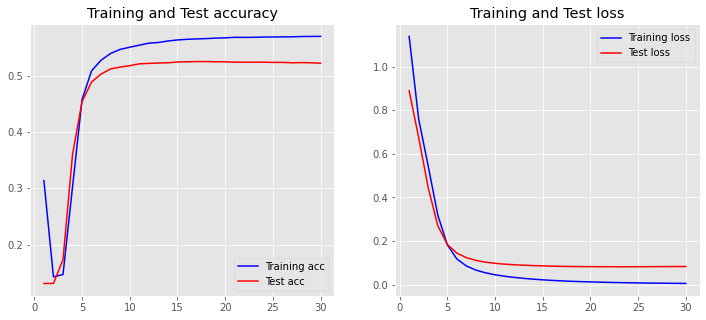

In [13]:
p_activation_d1 = 'sigmoid'
p_activation_d2 = 'tanh'
p_loss = 'mse'
p_optimizer = 'adam'
p_epochs = 30
p_batch_size = 128
p_verbose = 0
p_model_name = 'model_12'
model_12, result = create_embedding_1(p_model_name,p_optimizer, p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim, p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose)
df_score=df_score.append(OrderedDict(result),ignore_index=True)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model Name = model_13
p_vocab_size= 12135
p_embedding_dim= 64
p_max_length= 80
p_activation_d1= relu
p_activation_d2= tanh
p_optimizer= adam
p_loss= mse
p_epochs= 30
p_batch_size= 64
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 64)            776640    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1

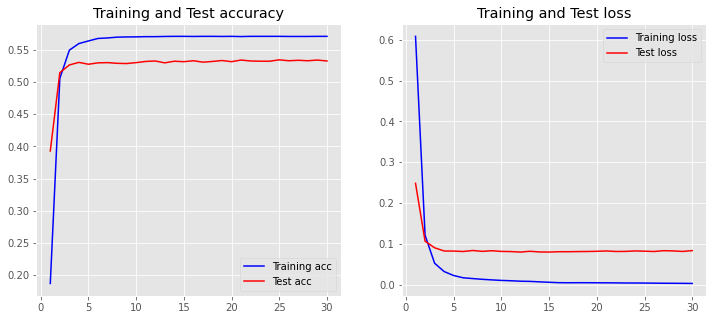

In [14]:
p_activation_d1 = 'relu'
p_activation_d2 = 'tanh'
p_loss = 'mse'
p_optimizer = 'adam'
p_epochs = 30
p_batch_size = 64
p_verbose = 0
p_model_name = 'model_13'
model_13, result = create_embedding_1(p_model_name, p_optimizer, p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim, p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose)
df_score=df_score.append(OrderedDict(result),ignore_index=True)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model Name = model_21
p_vocab_size= 12135
p_embedding_dim= 64
p_max_length= 80
p_activation_d1= sigmoid
p_activation_d2= tanh
p_optimizer= adam
p_loss= mse
p_epochs= 100
p_batch_size= 1028
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 64)            776640    
_________________________________________________________________
conv1d (Conv1D)              (None, 76, 128)           41088     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (N

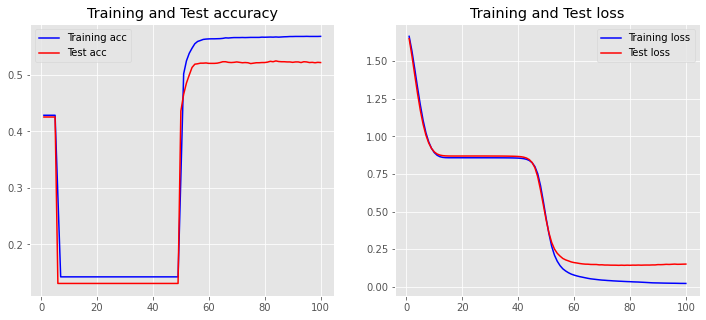

In [15]:
def create_embedding_2(p_model_name, p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose):
    print_info(p_model_name, p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, p_batch_size, p_epochs)
    
    model = Sequential()
    model.add(Embedding(input_dim=p_vocab_size, output_dim= p_embedding_dim, input_length=p_max_length))
    model.add(Conv1D(128, 5, activation=p_activation_d1))
    model.add(GlobalMaxPool1D())  
    model.add(Dropout(0.05))
    model.add(Dense(64, activation=p_activation_d1))    
    model.add(Dense(32, activation=p_activation_d1))  
    model.add(Dense(10, activation=p_activation_d1))
    model.add(Flatten())
    model.add(Dense(1, activation=p_activation_d2))
    model._name = p_model_name
    model.compile(loss=p_loss,optimizer=p_optimizer,metrics=['acc'])
    model.summary()
    
    loss_train, acc_train, loss_test, acc_test, training_duration = fit_and_evaluate_model(model, padded_train_sequences,train_label_arr, padded_test_sequences,test_label_arr, p_epochs, p_batch_size)
    
    result={'Model Name':p_model_name, 'Optimizer':p_optimizer, 'Activation':p_activation_d1,'Loss Func':p_loss,'Nb Epochs':p_epochs,
            'input_dim':p_vocab_size,'output_dim':p_embedding_dim,'input_length':p_max_length,'Batch size':p_batch_size,
            'Training Duration':training_duration,'Accuracy Train':(acc_train*100),'Loss Train':(loss_train*100),'Accuracy Test':(acc_test*100),'Loss Test':(loss_test*100)}
    
    return model, result


p_activation_d1 = 'sigmoid'
p_activation_d2 = 'tanh'
p_loss = 'mse'
p_optimizer = 'adam'
p_epochs = 100
p_batch_size = 1028
p_verbose = 0
p_model_name = 'model_21'
model_21, result = create_embedding_2(p_model_name, p_optimizer, p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim, p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose)
df_score=df_score.append(OrderedDict(result),ignore_index=True)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model Name = model_22
p_vocab_size= 12135
p_embedding_dim= 64
p_max_length= 80
p_activation_d1= relu
p_activation_d2= tanh
p_optimizer= adam
p_loss= mse
p_epochs= 100
p_batch_size= 1028
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 80, 64)            776640    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 76, 128)           41088     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None

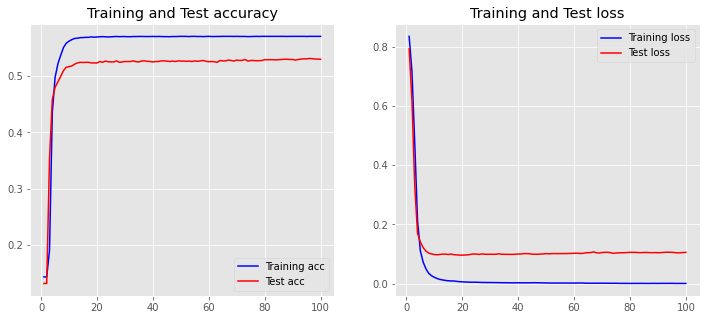

In [16]:
p_activation_d1 = 'relu'
p_activation_d2 = 'tanh'
p_loss = 'mse'
p_optimizer = 'adam'
p_epochs = 100
p_batch_size = 1028
p_verbose = 0
p_model_name = 'model_22'
model_22, result = create_embedding_2(p_model_name, p_optimizer, p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim, p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose)
df_score=df_score.append(OrderedDict(result),ignore_index=True)

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model Name = model_3
p_vocab_size= 12135
p_embedding_dim= 64
p_max_length= 80
p_activation_d1= relu
p_activation_d2= tanh
p_optimizer= adam
p_loss= mse
p_epochs= 50
p_batch_size= 128
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 80, 64)            776640    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                23000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16

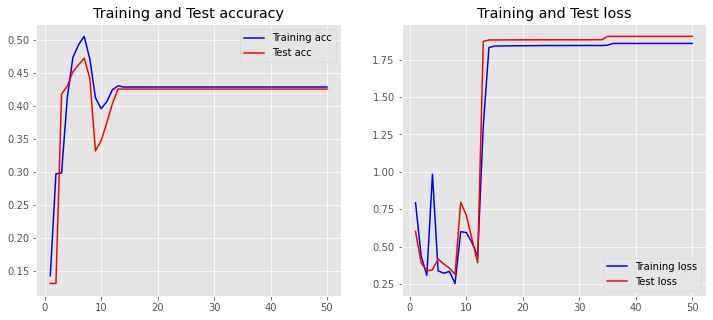

In [17]:
def create_embedding_3(p_model_name,p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose):
    print_info(p_model_name,p_optimizer,p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim,p_max_length, p_batch_size, p_epochs)
    
    model = Sequential()
    model.add(Embedding(input_dim=p_vocab_size, output_dim= p_embedding_dim, input_length=p_max_length))
    model.add(LSTM(units=50, activation= p_activation_d1, input_shape =(1,1)))
    model.add(Dropout(0.05))
    model.add(Dense(16, activation=p_activation_d1))
    model.add(Dense(1, activation=p_activation_d2))
    model._name = p_model_name
    model.compile(loss=p_loss,optimizer=p_optimizer,metrics=['acc'])
    model.summary()
    
    loss_train, acc_train, loss_test, acc_test, training_duration = fit_and_evaluate_model(model, padded_train_sequences,train_label_arr, padded_test_sequences,test_label_arr, p_epochs, p_batch_size)
    
    result={'Model Name':p_model_name,'Optimizer':p_optimizer, 'Activation':p_activation_d1,'Loss Func':p_loss,'Nb Epochs':p_epochs,
            'input_dim':p_vocab_size,'output_dim':p_embedding_dim,'input_length':p_max_length,'Batch size':p_batch_size,
            'Training Duration':training_duration,'Accuracy Train':(acc_train*100),'Loss Train':(loss_train*100),'Accuracy Test':(acc_test*100),'Loss Test':(loss_test*100)}
    
    return model, result


p_activation_d1 = 'relu'
p_activation_d2 = 'tanh'
p_loss = 'mse'
p_optimizer = 'adam'
p_epochs = 50
p_batch_size = 128
p_verbose = 0
p_model_name = 'model_3'
model_3, result = create_embedding_3(p_model_name,p_optimizer, p_activation_d1, p_activation_d2, p_loss, p_vocab_size, p_embedding_dim, p_max_length, padded_train_sequences,train_label_arr,padded_test_sequences,test_label_arr, p_batch_size, p_epochs, p_verbose)
df_score=df_score.append(OrderedDict(result),ignore_index=True)

In [18]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_score.sort_values(by=['Accuracy Test'], inplace=True, ascending=False)
df_score

,Accuracy Test,Accuracy Train,Activation,Batch size,Loss Func,Loss Test,Loss Train,Model Name,Nb Epochs,Optimizer,Training Duration,input_dim,input_length,output_dim
2,53.28,57.11,relu,64.00,mse,8.32,0.24,model_13,30.00,adam,29.55,12135.00,80.00,64.00
4,53.03,57.11,relu,1028.00,mse,10.52,0.02,model_22,100.00,adam,182.62,12135.00,80.00,64.00
1,52.23,57.03,sigmoid,128.00,mse,8.34,0.51,model_12,30.00,adam,19.33,12135.00,80.00,64.00
3,52.19,56.83,sigmoid,1028.00,mse,15.09,2.18,model_21,100.00,adam,185.36,12135.00,80.00,64.00
0,51.76,57.02,sigmoid,1028.00,mse,8.55,0.38,model_11,100.00,adam,35.44,12135.00,80.00,64.00
5,42.55,42.86,relu,128.00,mse,190.54,185.81,model_3,50.00,adam,198.83,12135.00,80.00,64.00


## <font color='RED'> Save Embedding </font>

In [27]:
import io

def save_embedding(model, vector_filename, meta_filename, p_vocab_size):
    e=model.layers[0]
    weights=e.get_weights()[0]
    weights.shape

    out_v=io.open(vector_filename,'w',encoding='utf-8')
    out_m=io.open(meta_filename,'w',encoding='utf-8')
    for idx in range(1,p_vocab_size):
        #print('idx:',idx)
        word=tokenizer.index_word[idx]
        vector=weights[idx]
        out_m.write(word+ "\n")
        out_v.write("\t".join([str(x) for x in vector]) +"\n")

    out_m.close()
    out_v.close()
    return

vector_filename = saved_embedding + 'emb_keras_vecs.tsv'
meta_filename = saved_embedding + 'emb_keras_meta.tsv'

save_embedding(model_13,vector_filename, meta_filename, p_vocab_size)
model_13.save(saved_models+'keras_sentiment_classification.h5')


## <font color='RED'> Use the Saved Model + Saved Word Embedding to predict the sentiment in sentences </font>

In [28]:
from keras import models
pd.set_option('display.float_format', lambda x: '%.2f' % x)

saved_model = models.load_model(saved_models+'keras_sentiment_classification.h5')
saved_model.summary()

def do_prediction(test_sen, p_max_length=80):
    test_seq=tokenizer.texts_to_sequences(test_sen)
    padded_test_seq=pad_sequences(test_seq,maxlen=p_max_length,truncating='post',padding="post")
    pred_label = saved_model.predict(padded_test_seq)
    return pred_label

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 64)            776640    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 777,697
Trainable params: 777,697
Non-trainable params: 0
_________________________________________________________________


In [29]:
p_max_length=80
test_sen=["The street noise at night was loud and disruptive. I cannot sleep. It's terrible"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.99811584]]


In [30]:
test_sen=["Beautiful quiet place to stay"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[0.97510266]]


In [31]:
test_sen=["The host cancel my booking before 3 check-in days."]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.90534925]]


In [32]:
test_sen=["I really like the place, great view and nice bathroom."]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[0.96786577]]


In [33]:
test_sen=["impressive place for vacation. Love it. Will back again."]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[0.9631085]]


In [34]:
test_folder = './data/test/'
test_file = test_folder + 'reviews_NewBrunswick_20210130.csv'
df_test = pd.read_csv(test_file)

test_comment_list = df_test['comments'].values.astype(str).tolist()
pred_label = do_prediction(test_comment_list,p_max_length)

print('RESULT')
df_testresult=pd.DataFrame()
df_testresult=df_test.copy()
df_testresult['pred_label'] = pred_label
df_testresult

RESULT


,listing_id,id,date,reviewer_id,reviewer_name,comments,labelled_by_Human,pred_label
0,75065,37146364,2015-07-05,30350931,Angie,We spent 4 nights at this beautiful cottage an...,1,1.00
1,75065,201946306,2017-10-09,133133,Shilei,We loved staying here! Having coffee and watch...,1,0.83
2,75065,279042769,2018-06-19,191448626,Sherri,Bob was an owner who was easily reachable if I...,1,0.99
3,75065,521126168,2019-08-31,122493946,Carrie,This location is amazing. It is close enough ...,1,-0.42
4,261800,664324641,2020-09-14,11266797,Laurie,A very roomy and comfortable apartment - it co...,1,0.97
5,950843,332982712,2018-10-06,213886811,Amanda,"Excellent service, lovely home with the extras...",1,1.00
6,950843,520524074,2019-08-30,287645565,Nadine,Gerry made our first Airbnb experience a fanta...,0,0.87
7,950843,581337664,2019-12-24,167838293,Kelsey,Great spot,1,0.98
8,950843,613106634,2020-03-01,245658668,Isabelle,Host is great but the place was unfortunately ...,-1,-0.05
9,986301,171895620,2017-07-19,31722140,David,Very spacious house with friendly owners. 3 se...,0,0.84


In [35]:
test_sen=["The place is wonderful, but the host is quite rude"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.3900215]]


In [36]:
test_sen=["The place is wonderful"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[0.9877117]]


In [37]:
test_sen=["There is not enough light in the bathroom"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.4459612]]


In [38]:
test_sen=["There is not enough light in the bathroom, it made me uncomfortable"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.9866566]]


In [39]:
test_sen=["The room is quite small. It is unacceptable with the price"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.82771134]]


In [40]:
test_sen=["There is no view from the window"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.20811269]]


In [41]:
test_sen=["You shouldn't try the food"]
pred_label = do_prediction(test_sen,p_max_length)
print(pred_label)

[[-0.3384045]]
